# Import Libraries and Data

In [67]:
import pandas as pd
from sklearn import preprocessing

import string
import torch
import torch.nn as nn
import random

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv("Datasets/names.csv")
df.shape

(10132, 2)

In [7]:
df.head()

,Name,Gender
0,Aamir,Male
1,Aaron,Female
2,Aaron,Male
3,Abagael,Female
4,Abagail,Female


In [10]:
len(df["Name"].unique())

9543

# Preprocessing

In [13]:
# Drop the duplicates and drop either the male or female name at random from the dataset
import random
df = df.drop_duplicates(subset=['Name'],keep=random.choice(['first', 'last']))
len(df)

9543

In [15]:
# Encode gender as numerical
le = preprocessing.LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])
df.head()

,Name,Gender
0,Aamir,1
2,Aaron,1
3,Abagael,0
4,Abagail,0
5,Abbe,0


In [16]:
genders=['Female', 'Male']

In [18]:
# Create a string of all the ascii characters plus some punctuation
let = string.ascii_letters + " .,;'"
num_lets = len(let)
let

"abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ .,;'"

In [21]:
# Function to convert to tensor

def convert(name):
    t = torch.zeros(len(name), 1, num_lets)  # 3d tensor of all ones.
    for i, letter in enumerate(name):        # iterate through all the characters in name
        t[i][0][let.find(letter)] = 1        # set the value to one for each of the characters in a name
        
    return t

In [23]:
convert('a')

tensor([[[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

In [24]:
convert('A')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0.]]])

# Build model

In [26]:
# Define class for RNN - credit Janini Ravi (Pluralsight)

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):  # three inputs to the initialisation function
        super(RNN, self).__init__()

        self.hidden_size = hidden_size   # number of input features to the hidden layer

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)  # first linear layer to hold internal state of the cell
        self.i2o = nn.Linear(input_size + hidden_size, output_size)  # linear layer to produce output
        self.softmax = nn.LogSoftmax(dim=1)  # log softmax to calculate output probabilities

    def forward(self, input, hidden):   # forward pass
        combined = torch.cat((input, hidden), 1)  # concat to produce a combined tensor
        hidden = self.i2h(combined)    # pass to the first hidden layer
        output = self.i2o(combined)    
        output = self.softmax(output)  # pass through log softmax layer
        return output, hidden

    def initHidden(self):  # function to return a zero tensor to initialise hidden state
        return torch.zeros(1, self.hidden_size)

In [31]:
# Define parameters
n_hidden = 128
n_genders= len(genders)

rnn = RNN(num_lets, n_hidden, output_size = n_genders)

In [33]:
# Set epochs, loss criterion and learning rate
epochs = 100000
criterion = nn.NLLLoss()
learning_rate = 0.005

In [34]:
# Function to return results
def output_to_gender (output):
    
    top_n, top_index = output.topk(1)
    pred_i = top_index[0].item()
    pred = genders[pred_i] 
    
    return pred

In [39]:
# Model training
for iteration in range(1 , iterations +1):

    i = random.randint(0, len(df) - 1)
    
    name = df.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender = df.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender])
    
    hidden = rnn.initHidden()
    rnn.zero_grad()

    for i in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[i], hidden)

    loss = criterion(output, gender_in_tensor)
    loss.backward()
    
    for p in rnn.parameters():
        p.data.add_(-learning_rate, p.grad.data)

    if iteration% 5000 == 0:
        
        pred = output_to_gender(output)
        
        correct = '✓' if pred == genders[gender] else '✗ (%s)' % genders[gender]
        print('iters- %d %d%% (%s) Name- %s Gender- %s %s' % \
              (iteration, iteration/iterations*100, loss.item(), name, pred, correct))


C:\Users\imoge\AppData\Local\Temp/ipykernel_17164/4238789885.py:21: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  p.data.add_(-learning_rate, p.grad.data)


iters- 5000 5% (0.0975315272808075) Name- Romonda Gender- Female ✓
iters- 10000 10% (0.5856207609176636) Name- Shalom Gender- Male ✓
iters- 15000 15% (0.4988815188407898) Name- Marthe Gender- Female ✓
iters- 20000 20% (3.3569939136505127) Name- Sasha Gender- Female ✗ (Male)
iters- 25000 25% (0.8899624943733215) Name- Ezequiel Gender- Female ✗ (Male)
iters- 30000 30% (0.16372212767601013) Name- Else Gender- Female ✓
iters- 35000 35% (0.8744443655014038) Name- Sau Gender- Male ✗ (Female)
iters- 40000 40% (0.021847642958164215) Name- Pepita Gender- Female ✓
iters- 45000 45% (0.029738960787653923) Name- Nada Gender- Female ✓
iters- 50000 50% (0.007161897141486406) Name- Lakisha Gender- Female ✓
iters- 55000 55% (0.26044273376464844) Name- Elsy Gender- Female ✓
iters- 60000 60% (0.7671680450439453) Name- Tracee Gender- Male ✗ (Female)
iters- 65000 65% (0.2540318965911865) Name- Radcliffe Gender- Male ✓
iters- 70000 70% (0.23865412175655365) Name- Caldwell Gender- Male ✓
iters- 75000 75% (0.

* choose name at random and convert this to a tensor
* convert the label to tensor
* initialise hidden layers
* predict for each character in the name and then get final prediction based on all the characters

In [42]:
n_confusion = 10000

prediction=[]
actual = []

for _ in range(n_confusion):

    i = random.randint(0, len(df) - 1)
    
    name = df.iloc[i][0]
    name_in_tensor = name_to_tensor(name)
    
    gender_idx = df.iloc[i][1]
    gender_in_tensor = torch.LongTensor([gender_idx])
        
    hidden = rnn.initHidden()

    for j in range(name_in_tensor.size()[0]):
        output, hidden = rnn(name_in_tensor[j], hidden)
    
    pred = output_to_gender(output)
    
    prediction.append(pred)
    actual.append(genders[gender_idx])

In [64]:
results = pd.DataFrame(actual,prediction).reset_index()
results.columns = ["Actual","Predicted"]
acc = results[results["Actual"] == results["Predicted"]].shape[0]/len(results)*100
print("Accuracy", acc)

Accuracy 82.27


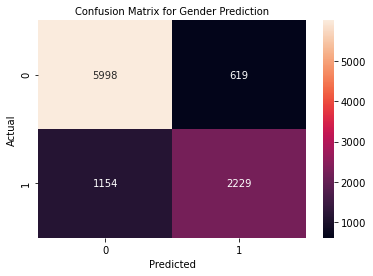

In [81]:
c = sns.heatmap(confusion_matrix(actual, prediction),annot = True, fmt = ".0f");
c.set_xlabel('Predicted', fontsize=10)
c.set_ylabel('Actual', fontsize=10)
plt.title("Confusion Matrix for Gender Prediction", fontsize = 10);